In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [39]:
class SimpleLinearClassifier(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleLinearClassifier, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.fc(x)

In [40]:
def load_df():
    df = pd.read_csv('seattle-weather.csv')

    weather_mapping = {"drizzle": 0, "rain": 1, "sun": 2, "snow": 3, "fog": 4}

    df['weather'] = df['weather'].map(weather_mapping)

    if df["weather"].isna().sum() > 0:
        raise ValueError("Unexpected weather categories found in dataset!")

    df = df.drop(columns=["date"])

    X = df.drop(columns=["weather"])
    y = df["weather"]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    return X_train, X_test, y_train, y_test

In [41]:
def train_pytorch_model(X_train, X_test, y_train, y_test, epochs=10, batch_size=32, learning_rate=0.01):
    device = torch.device("cpu")

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

    y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)
    y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

    input_dim = X_train.shape[1]  
    output_dim = len(set(y_train))  # Number of unique classes
    model = SimpleLinearClassifier(input_dim, output_dim).to(device)

    loss_fn = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    mse_history = []

    test_images, test_labels = next(iter(test_loader))
    test_images = test_images.to(device)
    test_labels_onehot = nn.functional.one_hot(test_labels, num_classes=output_dim).float().to(device)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            labels_onehot = nn.functional.one_hot(labels, num_classes=output_dim).float()

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels_onehot)
            loss.backward()
            optimizer.step()

        # Evaluate model on test set
        model.eval()
        with torch.no_grad():
            outputs = model(test_images)
            epoch_mse = loss_fn(outputs, test_labels_onehot).item()
        mse_history.append(epoch_mse)
        print(f"Epoch {epoch+1}/{epochs} - MSE: {epoch_mse:.4f}")

    return mse_history



In [42]:
def train_sklearn_models(X_train, X_test, y_train, y_test):

    X_train = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train
    X_test = X_test.to_numpy() if isinstance(X_test, pd.DataFrame) else X_test
    y_train = y_train.to_numpy() if isinstance(y_train, pd.Series) else y_train
    y_test = y_test.to_numpy() if isinstance(y_test, pd.Series) else y_test

    # SVM Model
    svm_model = SVC(kernel="linear", random_state=42)
    svm_model.fit(X_train, y_train)
    svm_preds = svm_model.predict(X_test)
    svm_mse = mean_squared_error(y_test, svm_preds)
    svm_accuracy = accuracy_score(y_test, svm_preds)
    print(f"SVM - Accuracy: {svm_accuracy*100:.2f}%, MSE: {svm_mse:.4f}")

    # Random Forest Model
    rf_model = RandomForestClassifier(max_depth=9, n_estimators=50, random_state=42)
    rf_model.fit(X_train, y_train)
    rf_preds = rf_model.predict(X_test)
    rf_mse = mean_squared_error(y_test, rf_preds)
    rf_accuracy = accuracy_score(y_test, rf_preds)
    print(f"RF - Accuracy: {rf_accuracy*100:.2f}%, MSE: {rf_mse:.4f}")

    return svm_mse, rf_mse, svm_model, rf_model


In [43]:
def plot_errors(lr_mse, svm_mse, rf_mse):
    epochs = np.arange(1, len(lr_mse) + 1)
    
    plt.figure(figsize=(10,6))
    plt.plot(epochs, lr_mse, 'r-o', label="PyTorch LR")
    
    plt.plot([1, epochs[-1]], [svm_mse, svm_mse], 'b--', label="SVM") 
    plt.plot([1, epochs[-1]], [rf_mse, rf_mse], 'g-.', label="RF")  

    
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("MSE vs Epoch: PyTorch LR vs. SVM and RF")
    plt.legend(loc="upper right")
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model, X_test, y_test, class_labels):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)

    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


Epoch 1/10 - MSE: 0.1048
Epoch 2/10 - MSE: 0.0913
Epoch 3/10 - MSE: 0.0882
Epoch 4/10 - MSE: 0.0878
Epoch 5/10 - MSE: 0.0861
Epoch 6/10 - MSE: 0.0867
Epoch 7/10 - MSE: 0.0862
Epoch 8/10 - MSE: 0.0850
Epoch 9/10 - MSE: 0.0857
Epoch 10/10 - MSE: 0.0854
SVM - Accuracy: 77.82%, MSE: 0.6416
RF - Accuracy: 83.62%, MSE: 0.5734


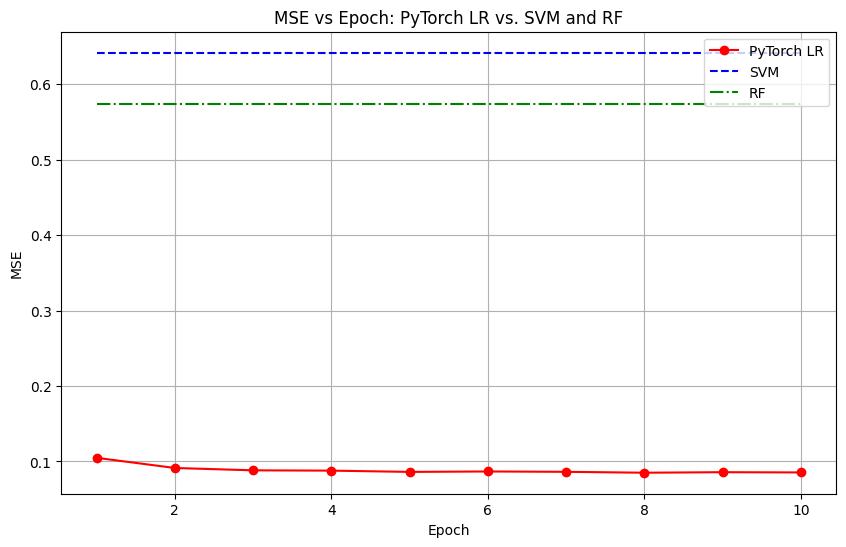

In [45]:
X_train, X_test, y_train, y_test = load_df()
lr_mse = train_pytorch_model(X_train, X_test, y_train, y_test, epochs=10, batch_size=32, learning_rate=0.01)
svm_mse, rf_mse, svm_model, rf_model  = train_sklearn_models(X_train, X_test, y_train, y_test)
plot_errors(lr_mse, svm_mse, rf_mse)

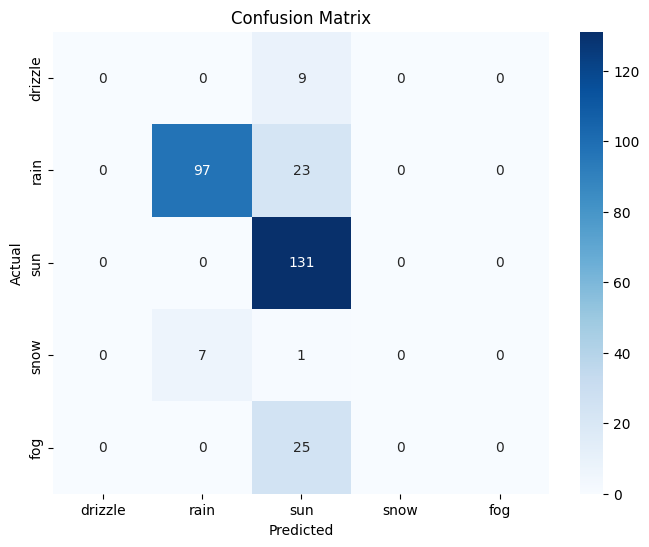

In [ ]:
plot_confusion_matrix(svm_model, X_test, y_test, ["drizzle", "rain", "sun", "snow", "fog"])